In [113]:
import os
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import keras
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint


print(f'Numpy Version: {np. __version__}')
print(f'TensorFlow Version: {tf. __version__}')
print(f'Keras Version: {keras. __version__}')

Numpy Version: 1.26.4
TensorFlow Version: 2.18.0
Keras Version: 3.7.0


In [114]:
# Load the quality-checked spectra and metadata from numpy variables
spectra = np.load('data/spectra.npy')
wl = np.load('data/wl.npy')
genus = np.load('data/genus.npy')
species = np.load('data/species.npy')
principle_part = np.load('data/principle_part.npy')
health = np.load('data/health.npy')
growth_stage = np.load('data/growth_stage.npy')
DateTimeId = np.load('data/DateTimeId.npy')
month = np.load('data/month.npy')
name = np.load('data/name.npy')# the genus and species if known, otherwise the common name (or material name for soil, road, etc.)
name_genus_species = np.load('data/name_genus_species.npy')# the genus and species if known - otherwise NA
name_full_category = np.load('data/name_full_category.npy')# all the metadata available in one string
plant_type = np.load('data/plant_type.npy')# the type of plant (tree, shrub, grass, etc.) - otherwise NA

nSpec = spectra.shape[0]
nBands = spectra.shape[1]
print(f'Min wavelength: {np.min(wl)}')
print(f'Max wavelength: {np.max(wl)}')
print(f'Number of Spectra: {nSpec}')
print(f'Number of Bands: {nBands}')

Min wavelength: 350.0
Max wavelength: 2500.0
Number of Spectra: 902
Number of Bands: 2151


In [115]:
# Assemble X and Y for training
X = spectra
Yn = name
Yg = genus
Ys = species
Ypp = principle_part
Yh = health
Ygs = growth_stage
Yd = DateTimeId
Ym = month
Yngs = name_genus_species
Ynfc = name_full_category
Ypt = plant_type
print(X.shape,Yn.shape)
print(f'Number of genus: {len(np.unique(Yg))}: {np.unique(Yg)}\n')
print(f'Number of species: {len(np.unique(Ys))}: {np.unique(Ys)}\n')
print(f'Number of principle_parts: {len(np.unique(Ypp))}: {np.unique(Ypp)}\n')
print(f'Number of health categories: {len(np.unique(Yh))}: {np.unique(Yh)}\n')
print(f'Number of growth stage categories: {len(np.unique(Ygs))}: {np.unique(Ygs)}\n')
print(f'Number of Date-Time_Id values: {len(np.unique(Yd))}\n')
print(f'Number of months: {len(np.unique(Ym))}: {np.unique(Ym)}\n')
print(f'Number of names: {len(np.unique(Yn))}: {np.unique(Yn)}\n')
print(f'Number of name_genus_species categories: {len(np.unique(Yngs))}: {np.unique(Yngs)}\n')
print(f'Number of name_full_categories: {len(np.unique(Ynfc))}\n')
print(f'Number of plant types: {len(np.unique(Ypt))}: {np.unique(Ypt)}\n')

(902, 2151) (902,)
Number of genus: 10: ['Ammophila' 'Baccharis' 'Chamaecrista' 'Chasmanthium' 'Ilex' 'Iva' 'NA'
 'Panicum' 'Rosa' 'Solidago']

Number of species: 11: ['NA' 'amarum' 'breviligulata' 'fasciculata' 'frutescens' 'halimifolia'
 'latifolium' 'rugosa' 'sempervirens' 'virgatum' 'vomitoria']

Number of principle_parts: 10: ['B' 'CS' 'FL' 'L' 'MX' 'NA' 'RS' 'S' 'SA' 'St']

Number of health categories: 7: ['D' 'H' 'LLRZ' 'MX' 'NA' 'R' 'S']

Number of growth stage categories: 8: [' M' '1G' 'D' 'E' 'FL' 'M' 'NA' 'RE']

Number of Date-Time_Id values: 902

Number of months: 8: ['01' '02' '03' '04' '07' '10' '11' '12']

Number of names: 18: ['Ammophila_breviligulata' 'Baccharis_halimifolia'
 'Chamaecrista_fasciculata' 'Chasmanthium_latifolium' 'Ilex_vomitoria'
 'Iva_frutescens' 'Panicum_amarum' 'Panicum_virgatum' 'Rosa_rugosa'
 'Solidago_sempervirens' 'clay' 'golf-course-sand' 'grass' 'iris'
 'milkweed' 'pasturegrass' 'soybean' 'timothy']

Number of name_genus_species categories: 11: 

In [116]:
Y_type = Yn
Y_labels = np.unique(Y_type)
nClasses = len(Y_labels)
Y = np.zeros(nSpec, dtype=int)
for i in range(nSpec):
    Y[i] = np.where(Y_labels == Y_type[i])[0]

In [117]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [118]:
# from scipy.signal import savgol_filter
# smoothed_spectra = savgol_filter(X, window_length=11, polyorder=2, axis=1)

In [119]:
# Create a test-train split
X_train80, X_test, Y_train80, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42) # 20% of the data in the test set
X_train, X_val, Y_train, Y_val = train_test_split(X_train80, Y_train80, test_size=0.25, random_state=42) # 20% of the data in the validation set, 60% in the training set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])
print(X_val.shape,Y_val.shape[0] / Y.shape[0])

(540, 2151) 0.5986696230598669
(181, 2151) 0.2006651884700665
(181, 2151) 0.2006651884700665


In [120]:
# Learning rate schedule
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.96, staircase=True)

# Model Definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nClasses, activation='softmax')
])

In [121]:

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)


In [122]:
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.keras', 
                             monitor='val_accuracy',  # Track validation accuracy
                             mode='max',               # Maximize accuracy
                             save_best_only=True,      # Save only the best model
                             verbose=1)

# Fit the model with validation data and checkpoint callback
history = model.fit(X_train, Y_train, epochs=2000, batch_size=32,
                    validation_data=(X_val, Y_val),  # Make sure to provide validation data
                    callbacks=[checkpoint])  # Include the checkpoint callback


Epoch 1/2000
 1/17 ━━━━━━━━━━━━━━━━━━━━ 15s 956ms/step - accuracy: 0.0312 - loss: 6.3036
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0715 - loss: 5.9812 - val_accuracy: 0.0000e+00 - val_loss: 5.4055
Epoch 2/2000
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2188 - loss: 5.3852
Epoch 2: val_accuracy improved from 0.00000 to 0.10497, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2523 - loss: 5.0351 - val_accuracy: 0.1050 - val_loss: 5.5598
Epoch 3/2000
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2188 - loss: 4.8261
Epoch 3: val_accuracy improved from 0.10497 to 0.12155, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3071 - loss: 4.5664 - val_accuracy: 0.1215 - val_loss: 5.4174
Epoch 4/2000
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4062 - loss: 4.1624
Epoch 4: val_accuracy improved from 

In [123]:
best_model = tf.keras.models.load_model('best_model.keras')

# Get the epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])  # Index of the highest validation accuracy
best_val_acc = history.history['val_accuracy'][best_epoch]  # Best validation accuracy value

# Print the epoch and the corresponding validation accuracy
print(f'Best Epoch: {best_epoch + 1}')  # +1 because epoch is 0-indexed
print(f'Best Validation Accuracy: {best_val_acc}')

Best Epoch: 1819
Best Validation Accuracy: 0.8784530162811279


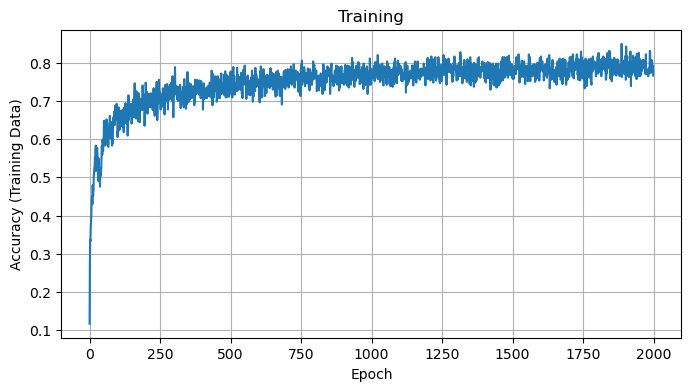

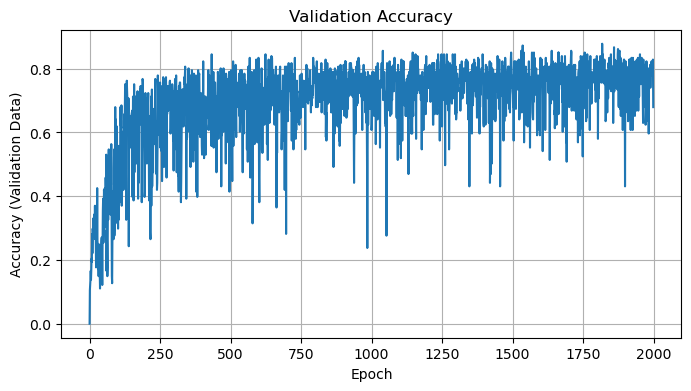

In [124]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Training Data)')
plt.title('Training');
plt.savefig('trainingHistoryAccuracy.png')

plt.figure(figsize=(8,4))
plt.plot(history.history['val_accuracy'])  # Use 'val_accuracy' for validation accuracy
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Validation Data)')  # Update the label to indicate validation data
plt.title('Validation Accuracy')
plt.savefig('validationHistoryAccuracy.png')  # Save as a new plot for validation accuracy


In [125]:
test_loss, test_acc = best_model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest accuracy:', test_acc)

6/6 - 0s - 32ms/step - accuracy: 0.8674 - loss: 0.7036

Test accuracy: 0.8674033284187317


In [126]:
predicted = model.predict(X_test)
actual = tf.stack(Y_test, axis=0)
predicted = tf.concat(predicted, axis=0)
predicted = tf.argmax(predicted, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


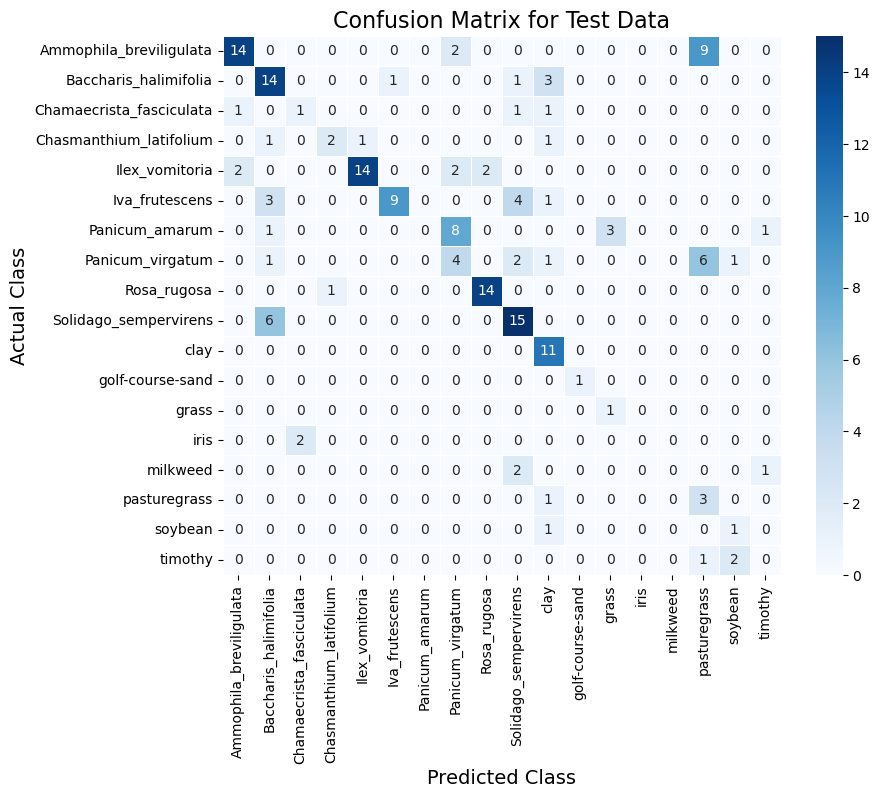

In [130]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = tf.math.confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title(f'Confusion Matrix for {ds_type.capitalize()} Data', fontsize=16)
    ax.set_xlabel('Predicted Class', fontsize=14)
    ax.set_ylabel('Actual Class', fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(actual, predicted, Y_labels, 'test')
plt.savefig('confusionMatrix.png')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


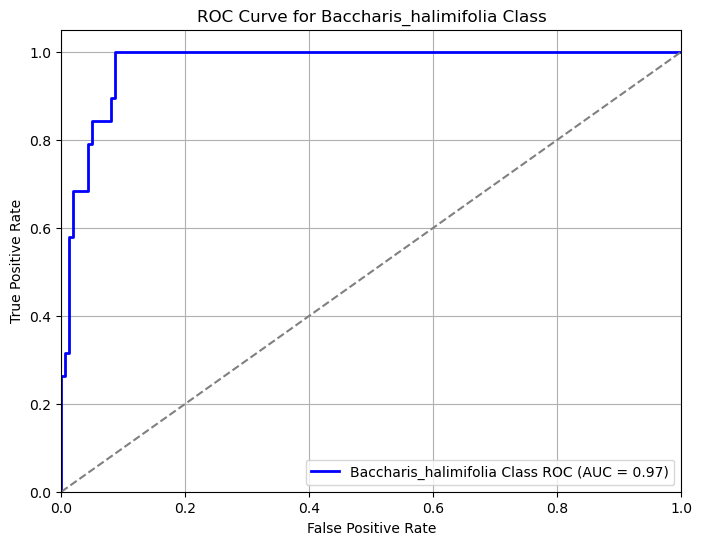

AUC for Baccharis_halimifolia class: 0.9740


In [131]:
# Get the class label for Baccharus (change the class index as per your dataset)
baccharus_class_index = np.where(Y_labels == 'Baccharis_halimifolia')[0][0]  # Make sure 'Baccharus' matches the actual class name in your dataset

# Get the predicted probabilities for all classes
predicted_probs = best_model.predict(X_test)

# Binarize the labels to one-hot encoding for multi-class ROC calculation
lb = LabelBinarizer()
Y_test_bin = lb.fit_transform(Y_test)

# Get the true labels for the Baccharus class
y_true = Y_test_bin[:, baccharus_class_index]

# Get the predicted probabilities for the Baccharus class
y_pred = predicted_probs[:, baccharus_class_index]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Baccharis_halimifolia Class ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Baccharis_halimifolia Class')
plt.legend(loc='lower right')
plt.grid(True)

# Save the plot
plt.savefig('Baccharis_halimifolia.png')
plt.show()

print(f'AUC for Baccharis_halimifolia class: {roc_auc:.4f}')
